# Analyzing Independent Medical Review Decisions Using NLP
## Introduction
The dataset used in this notebook contains detailed records of Independent Medical Reviews (IMRs) administered by the California Department of Managed Health Care (DMHC). IMRs are conducted when a health plan denies, delays, or modifies a healthcare service by determining it to be medically unnecessary, experimental, or non-urgent. The dataset spans several years, capturing information such as diagnosis, treatment, reviewer findings, and final determinations (Overturned or Upheld).
This notebook leverages Natural Language Processing (NLP) techniques to uncover insights into medical review decisions. By analyzing the text data, we aim to understand trends, reviewer justifications, and the factors influencing overturned or upheld decisions. The project explores text preprocessing, exploratory data analysis, sentiment analysis, and predictive modeling to provide a comprehensive understanding of the dataset.
Through this exploration, we seek to enhance transparency in healthcare decision-making, identify patterns in patient treatment approvals, and potentially inform future policy decisions regarding healthcare accessibility.

### Import Libraries
This section imports essential libraries for data manipulation, visualization, natural language processing (NLP), and machine learning. Libraries like pandas, nltk, and sklearn are used for data handling and preprocessing, while matplotlib and seaborn are used for visualizations. Ensure you have all dependencies installed before proceeding.

In [1]:
# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline

### Load the Dataset
Here, the dataset is loaded into a pandas DataFrame. We inspect the structure of the dataset, check for missing values, and understand the nature of the data to be analyzed. This step provides a foundation for further exploration and preprocessing.

In [2]:
# Load dataset into a pandas DataFrame
file_path = "D:/Independent_Medical_Review__IMR__Determinations__Trend.csv"
df = pd.read_csv(file_path)

# View dataset structure
print(df.head())

  Reference ID  Report Year      Diagnosis Category Diagnosis Sub Category  \
0   MN16-22639         2016              Infectious              Hepatitis   
1   MN16-22638         2016                  Mental        Eating Disorder   
2   MN16-22637         2016         Autism Spectrum         Autism-PDD-NOS   
3   EI16-22636         2016  Prevention/Good Health                    NaN   
4    EI06-5319         2006     Cardiac/Circulatory                    NaN   

                          Treatment Category  \
0                Pharmacy/Prescription Drugs   
1                    Mental Health Treatment   
2                   Autism Related Treatment   
3  Diagnostic Imaging, Screening and Testing   
4                            Cardio Vascular   

                     Treatment Sub Category  \
0                               Anti-virals   
1  Residential Treatment Center - Admission   
2                            Speech Therapy   
3                               Mammography   
4      

### Explore Dataset Columns
This section provides an overview of the dataset by analyzing the distribution of values in key columns, identifying missing values, and exploring unique entries in categorical columns like Diagnosis Category, Treatment Category, and Determination. This step helps us familiarize ourselves with the dataset.

In [3]:
# Check for null values
print(df.isnull().sum())

# Analyze unique values in key columns
print(df['Diagnosis Category'].value_counts())
print(df['Treatment Category'].value_counts())
print(df['Determination'].value_counts())

# Basic statistics for numerical columns
print(df.describe())

Reference ID                 0
Report Year                  0
Diagnosis Category          59
Diagnosis Sub Category    1904
Treatment Category         450
Treatment Sub Category    1268
Determination                0
Type                         0
Age Range                 1210
Patient Gender            1210
Findings                    20
dtype: int64
Diagnosis Category
Orthopedic/ Musculoskeletal              3469
Mental                                   2512
Cancer                                   1681
Central Nervous System/ Neuromuscular    1620
Infectious                               1059
Cardiac/Circulatory                       965
Morbid Obesity                            824
OB-Gyn/ Pregnancy                         801
Endocrine/ Metabolic                      779
Digestive System/ Gastrointestinal        758
Pediatrics                                709
Autism Spectrum                           524
Respiratory System                        513
Skin                         

### Visualize Basic Trends
Using visualizations, we explore key patterns and trends in the dataset. For example, we visualize the proportion of overturned vs. upheld decisions, the distribution of diagnosis categories, and year-wise trends in determinations. These insights lay the groundwork for deeper analysis.

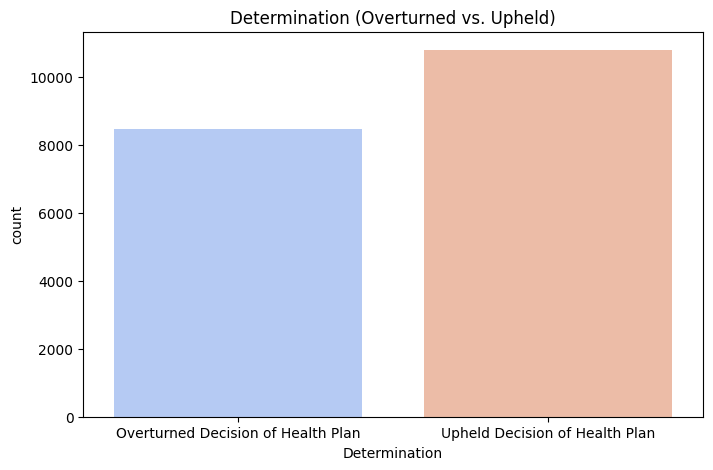

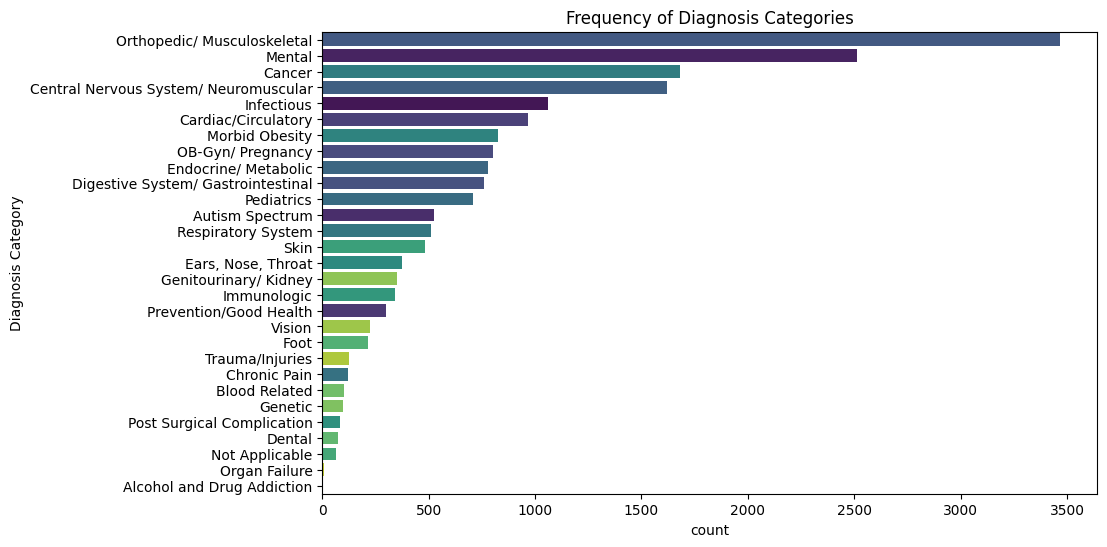

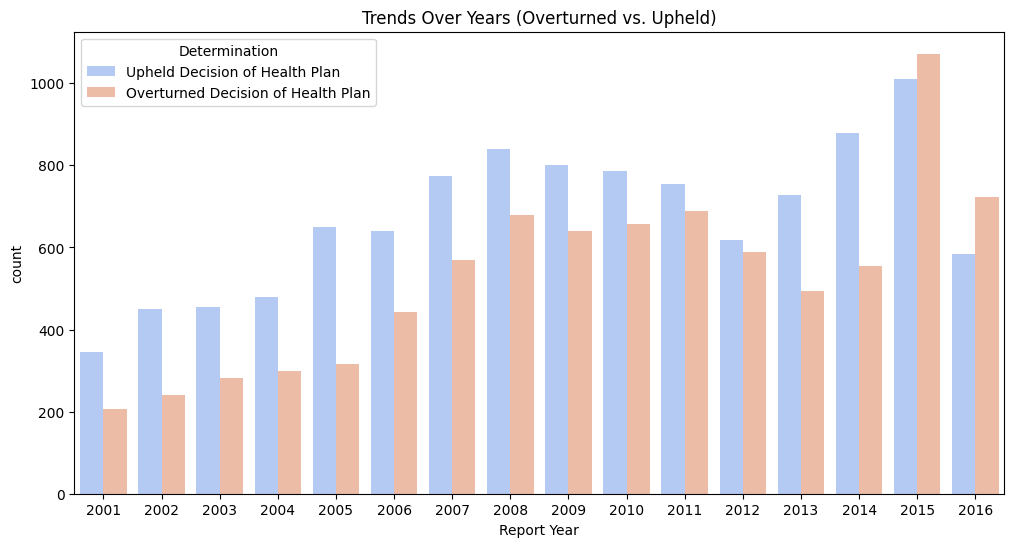

In [4]:
# Proportion of Overturned vs. Upheld decisions
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Determination', hue='Determination', palette='coolwarm', legend=False)
plt.title('Determination (Overturned vs. Upheld)')
plt.show()

# Diagnosis Category distribution
plt.figure(figsize=(10, 6))
sns.countplot(
    data=df,
    y='Diagnosis Category',
    order=df['Diagnosis Category'].value_counts().index,
    hue='Diagnosis Category',
    palette='viridis',
    legend=False
)
plt.title('Frequency of Diagnosis Categories')
plt.show()

# Year-wise trends for determinations
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Report Year', hue='Determination', palette='coolwarm')
plt.title('Trends Over Years (Overturned vs. Upheld)')
plt.show()

### Preprocess Text Data
In this section, we clean the text data in the Findings column. Text preprocessing involves tokenization, removal of stopwords, and lemmatization. This step prepares the data for downstream tasks such as topic modeling, sentiment analysis, and predictive modeling.

In [5]:
import nltk
nltk.data.path.append('C:\\Users\\kipye\\nltk_data')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import pandas as pd
import re
import html

# Function for text cleaning
def preprocess_text(text):
    # Convert text to string (in case of NaN or unexpected types)
    text = str(text)
    # Remove HTML entities
    text = html.unescape(text)
    # Remove unnecessary sections (like "Nature of Statutory Criteria", "Final Result", etc.)
    text = re.sub(r"(Nature of Statutory Criteria/Case Summary:|Final Result:|Credentials/Qualifications:)", "", text, flags=re.IGNORECASE)
    # Remove special characters, numbers, and extra spaces
    text = re.sub(r"[^a-zA-Z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    # Lowercase and tokenize
    tokens = word_tokenize(text.lower())
    # Lemmatize and remove stopwords
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]
    # Join tokens back into a single string
    return ' '.join(tokens)

# Apply preprocessing to the Findings column
df['Cleaned_Findings'] = df['Findings'].apply(preprocess_text)

### Generate Word Clouds
Word clouds visually represent the most frequent terms in the Findings column. Separate word clouds are generated for overturned and upheld decisions to identify differences in language and terminology between the two categories.

Cleaned unique values in Determination column:
['Overturned' 'Upheld']
Overturned Data Sample: 0     enrollee requested harvoni treatment hepatitis...
3     enrollee requested breast tomosynthesis evalua...
6     enrollee requested breast tomosynthesis evalua...
7     enrollee requested breast tomosynthesis evalua...
10    enrollee requested breast tomosynthesis evalua...
Name: Cleaned_Findings, dtype: object
Upheld Data Sample: 1    enrollee requested residential treatment cente...
2    parent enrollee requested speech therapy treat...
4    physician patient year old male reported small...
5    enrollee requested advanced lipoprotein testin...
8    parent enrollee requested occupational therapy...
Name: Cleaned_Findings, dtype: object


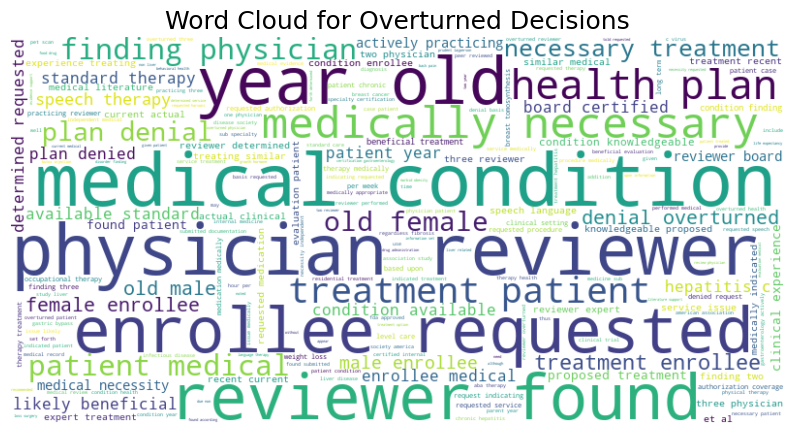

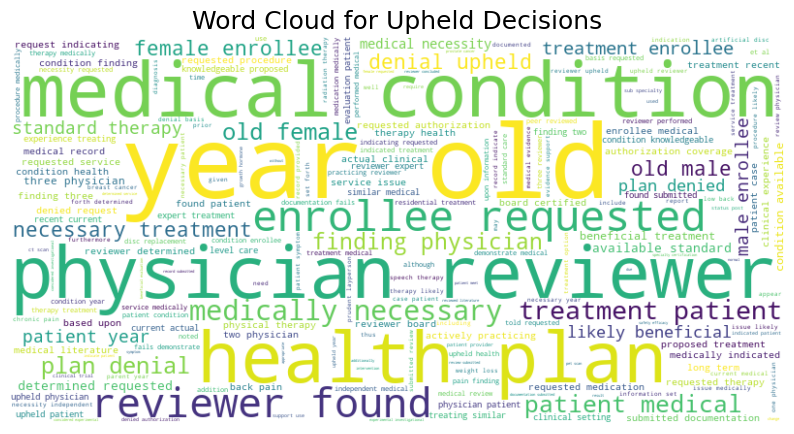

In [6]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to generate and display a word cloud
def generate_wordcloud(data, title):
    if data.empty:
        print(f"No data available for {title}. Skipping WordCloud generation.")
        return
    text = ' '.join(data)
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white', 
        colormap='viridis', 
        max_words=200
    ).generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=18)
    plt.show()

# Extract the first word ('Overturned' or 'Upheld') from the Determination column
df['Determination'] = df['Determination'].str.split(' ', expand=True)[0]

# Verify unique values
print("Cleaned unique values in Determination column:")
print(df['Determination'].unique())

# Filter data for Overturned and Upheld decisions
overturned_data = df[df['Determination'] == 'Overturned']['Cleaned_Findings'].dropna()
print("Overturned Data Sample:", overturned_data.head())

upheld_data = df[df['Determination'] == 'Upheld']['Cleaned_Findings'].dropna()
print("Upheld Data Sample:", upheld_data.head())

# Generate WordClouds
generate_wordcloud(overturned_data, title='Word Cloud for Overturned Decisions')
generate_wordcloud(upheld_data, title='Word Cloud for Upheld Decisions')

### Vectorize Text Data
The Findings text is converted into numerical representations using TF-IDF vectorization. This process helps us quantify textual data, making it suitable for machine learning models. The target variable (Determination) is encoded as binary (1 for Overturned, 0 for Upheld).

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Vectorize using TF-IDF
tfidf = TfidfVectorizer(max_features=500)  # Limit to 500 most important features
X = tfidf.fit_transform(df['Cleaned_Findings']).toarray()  # Transform the cleaned text

# Encode the Determination column as the target variable
y = df['Determination'].apply(lambda x: 1 if x == 'Overturned' else 0)  # Binary encoding

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display shapes of the resulting datasets
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (15396, 500)
Test data shape: (3849, 500)


### Train a Predictive Model
A Random Forest classifier is trained to predict whether a decision will be overturned or upheld based on the textual findings. This section includes splitting the data into training and test sets, evaluating model performance using accuracy, and visualizing the results with a confusion matrix.

Accuracy: 0.8706157443491817
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.92      0.89      2174
           1       0.88      0.81      0.85      1675

    accuracy                           0.87      3849
   macro avg       0.87      0.86      0.87      3849
weighted avg       0.87      0.87      0.87      3849



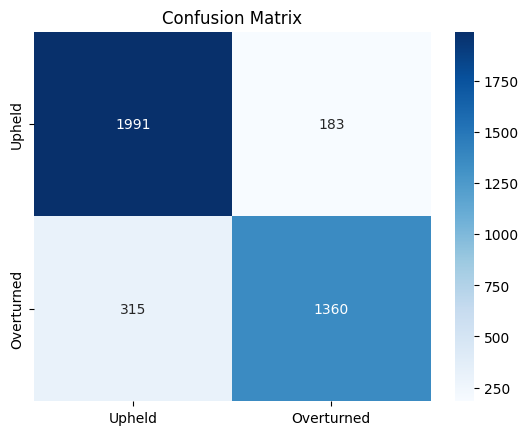

Top Features: ['overturned', 'upheld', 'evidence', 'demonstrate', 'fails', 'lack', 'denial', 'finding', 'documentation', 'health']


In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Upheld', 'Overturned'], yticklabels=['Upheld', 'Overturned'])
plt.title('Confusion Matrix')
plt.show()

# Analyze feature importance
feature_importances = model.feature_importances_
top_indices = feature_importances.argsort()[-10:][::-1]
top_features = [tfidf.get_feature_names_out()[i] for i in top_indices]
print("Top Features:", top_features)

### Topic Modeling
Using Latent Dirichlet Allocation (LDA), we identify hidden themes in the `Findings` column. Topic modeling uncovers patterns in how different medical review decisions are justified, providing valuable insights into the dataset's textual content.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Validate Cleaned_Findings
df = df[df['Cleaned_Findings'].notnull() & (df['Cleaned_Findings'].str.strip() != '')]

# Vectorize the text data for LDA
count_vectorizer = CountVectorizer(max_features=500, stop_words='english')
X_topics = count_vectorizer.fit_transform(df['Cleaned_Findings'])

# Perform LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X_topics)

# Display topics with top words
for i, topic in enumerate(lda.components_):
    print(f"Topic {i+1}:")
    print({count_vectorizer.get_feature_names_out()[j]: topic[j] for j in topic.argsort()[-10:]})

Topic 1:
{'parent': 1989.0821425367935, 'year': 2262.1780297522796, 'requested': 2562.241665658962, 'enrollee': 2651.3282740787668, 'language': 2760.1995900528777, 'treatment': 3231.830709890972, 'child': 3300.46753609255, 'patient': 5276.968161297068, 'speech': 5740.199203094472, 'therapy': 9132.034527339274}
Topic 2:
{'finding': 4607.098726972808, 'standard': 4767.289678595881, 'old': 5216.03929658655, 'physician': 5253.313569579566, 'year': 6111.789187167443, 'pain': 7913.624493643428, 'requested': 8078.803020996182, 'therapy': 10257.270750451198, 'treatment': 14611.199076515231, 'patient': 16960.11020991733}
Topic 3:
{'medically': 8609.700998603575, 'enrollee': 8741.499675350715, 'patient': 9863.428497795487, 'health': 11987.125583433475, 'requested': 12358.746633253739, 'plan': 12369.205521453408, 'reviewer': 12695.215641519628, 'condition': 13300.119103891593, 'medical': 16787.913072956013, 'treatment': 17547.81470346576}
Topic 4:
{'physician': 3799.361090654421, 'old': 3800.9583

# Analysis and Conclusion for the NLP Notebook on IMR Decisions

## Analysis

This project used Natural Language Processing (NLP) techniques to analyze Independent Medical Review (IMR) decisions, uncovering trends, reviewer justifications, and factors influencing outcomes. Key findings from the analysis include:

### 1. Distribution of Determinations
- The dataset showed a higher proportion of upheld decisions compared to overturned ones.
- Visualizations highlighted these differences clearly, providing insights into trends over time and the types of cases more likely to be overturned.

### 2. Diagnosis and Treatment Patterns
- **Diagnosis Categories**: Orthopedic and musculoskeletal conditions were the most frequently reviewed.
- **Treatment Categories**: Pharmacy/prescription drugs and diagnostic imaging were prominent in both overturned and upheld cases.
- Certain diagnosis categories had stronger associations with overturned decisions, highlighting potential challenges faced by patients in securing approvals.

### 3. Text Data Insights
- **Word Clouds**: Thematic differences emerged between overturned and upheld decisions. Terms such as "reviewer," "necessary," and "finding" were common but carried different connotations.
- Overturned cases featured terms like "denial," "evidence," and "documentation," suggesting the importance of medical necessity and supporting documentation.

### 4. Predictive Modeling
- The Random Forest classifier achieved an **accuracy of 87%**, with balanced precision, recall, and F1-scores for both overturned and upheld cases.
- Feature importance analysis identified terms like "overturned," "upheld," "evidence," and "documentation" as critical predictors, emphasizing the role of language in the findings.

### 5. Topic Modeling
- **Latent Dirichlet Allocation (LDA)** revealed five key topics, highlighting common narratives in IMR decisions:
  - Patient conditions
  - Treatment justifications
  - Reviewer findings
- These topics provided insights into themes such as medical necessity, patient demographics, and physician evaluations.

## Conclusion

This analysis showcased the potential of NLP in extracting valuable insights from IMR text data. By leveraging text preprocessing, visualization, predictive modeling, and topic analysis, the study offered a comprehensive understanding of factors influencing healthcare decision-making.

### Implications:
1. **Policy Recommendations**: Clarify documentation and evidence requirements to reduce overturned decisions.
2. **Transparency**: Enhance public understanding of trends in healthcare accessibility.
3. **Future Research**: Explore advanced NLP techniques, such as sentiment analysis or transformer-based models, for deeper insights.

This notebook serves as a foundational step in applying NLP to inform healthcare policies, aiming to improve patient outcomes and address disparities in medical reviews.